Binary 1/6 C)


mRNA localization using binary classification (cytoplasm/endoplasmic reticulum) (part 1/2): basic model with: <br> 
<br>
a) Method 6: no feature selection and class weights accounted for <br>
b) Method 7: with feature importance-based feature selection (SHAP), w/ threshold > 0  and class weights accounted for<br>

In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import shap

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, classification_report


In [14]:
#data initialization

#Cytoplasm (label = 0)
CP_train = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_train_CSV.csv")
CP_test = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_test_CSV.csv")

#Endoplasmic reticulum (label = 1)
ER_train = pd.read_csv("../../Data/InputData/ER_iLearnfeatvalues_train_CSV.csv")
ER_test = pd.read_csv("../../Data/InputData/ER_iLearnfeatvalues_test_CSV.csv")

print("CP TRAIN, TEST SHAPE:", CP_train.shape, ",", CP_test.shape)
print("ER TRAIN, TEST SHAPE:", ER_train.shape, ",", ER_test.shape)

CP TRAIN, TEST SHAPE: (824, 1026) , (206, 1026)
ER TRAIN, TEST SHAPE: (296, 1026) , (74, 1026)


In [4]:
###### NEXT STEP #######
#Merge training files for binary classification (CP+ER, CP+MT, CP+NU, ER+MT, ER+NU, MT+NU)
#Merge testing files same way

#How to merge: 
# - https://saturncloud.io/blog/how-to-merge-two-csv-files-into-one-with-pandas-by-id/
# or pd.concat


In [5]:
#Group 1: CP + ER

frames_EC_tra = [CP_train, ER_train]
frames_EC_tes = [CP_test, ER_test]

CP_ER_train = pd.concat(frames_EC_tra)
CP_ER_test = pd.concat(frames_EC_tes)



In [6]:
print("CP + ER TRAIN, TEST SHAPE:", CP_ER_train.shape, ",", CP_ER_test.shape)


CP + ER TRAIN, TEST SHAPE: (1120, 1026) , (280, 1026)


In [7]:
CP_ER_test.head(209)

,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_16986#79230|0|testing,0,0.008836,0.002834,0.002334,0.003168,0.001667,0.003168,0.000000,0.002001,...,0.000834,0.001834,0.001167,0.000500,0.001667,0.001834,0.001667,0.002501,0.002001,0.011504
1,mRNALoc_8139#3082|0|testing,0,0.009503,0.002501,0.003168,0.006002,0.003001,0.000834,0.000167,0.002668,...,0.000167,0.003168,0.001667,0.001334,0.001667,0.003501,0.005835,0.001667,0.003501,0.005669
2,mRNALoc_19034#8816|0|testing,0,0.006005,0.001168,0.002168,0.001168,0.001668,0.001334,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001501,0.000667,0.001668,0.002502,0.001001,0.001334,0.002002
3,mRNALoc_19863#9737|0|testing,0,0.005673,0.001335,0.002503,0.002837,0.001502,0.001335,0.000167,0.001001,...,0.000000,0.001168,0.002002,0.001001,0.002670,0.001001,0.001168,0.000834,0.001669,0.001502
4,mRNALoc_19031#8816|0|testing,0,0.006008,0.001168,0.002170,0.001168,0.001669,0.001335,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001502,0.000668,0.001669,0.002503,0.001001,0.001335,0.002003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,mRNALoc_8179#30957|0|testing,0,0.000732,0.000183,0.000366,0.000732,0.000549,0.000366,0.000183,0.000732,...,0.000000,0.000183,0.000366,0.000732,0.000732,0.000549,0.000183,0.000183,0.000549,0.000000
205,mRNALoc_19660#94229|0|testing,0,0.006595,0.001465,0.002748,0.002565,0.002015,0.000550,0.000183,0.001099,...,0.000183,0.002381,0.003114,0.001649,0.001465,0.001832,0.002931,0.002565,0.003297,0.004396
0,mRNALoc_9547#3911|1|testing,1,0.001311,0.000087,0.000262,0.000262,0.000000,0.000437,0.000175,0.000175,...,0.000087,0.000262,0.000175,0.000262,0.001224,0.000612,0.000175,0.000087,0.000175,0.000175
1,mRNALoc_11948#55102|1|testing,1,0.002614,0.000991,0.001893,0.003245,0.001532,0.000811,0.000541,0.001532,...,0.000180,0.002614,0.001442,0.001712,0.002073,0.001532,0.003335,0.002704,0.002524,0.003064


In [8]:
#Remove name/symbol column and separate labels and variables from training and testing data

#FOR CP+ER
noname_CE_train = CP_ER_train.drop("#", axis="columns")
noname_CE_test = CP_ER_test.drop("#", axis="columns")


CP_ER_X_train = noname_CE_train.drop("label", axis="columns")
CP_ER_y_train = noname_CE_train["label"]

CP_ER_X_test = noname_CE_test.drop("label", axis="columns")
CP_ER_y_test = noname_CE_test["label"]

print("CP + ER X train:", CP_ER_X_train.shape)
print("CP + ER y train:", CP_ER_y_train.shape)
print("CP + ER X test:", CP_ER_X_test.shape)
print("CP + ER y test:", CP_ER_y_test.shape)

CP + ER X train: (1120, 1024)
CP + ER y train: (1120,)
CP + ER X test: (280, 1024)
CP + ER y test: (280,)


In [9]:
# Create data pools for feature importance/selection for CP + ER

CE_feature_names = list(CP_ER_X_train.columns)
print("Number of features:", len(CE_feature_names))

CE_train_pool = Pool(CP_ER_X_train, CP_ER_y_train, feature_names=CE_feature_names)

CE_test_pool = Pool(CP_ER_X_test, CP_ER_y_test)

print("*Cytoplasm, ER Pools created")

Number of features: 1024
*Cytoplasm, ER Pools created


    Method 6: Basic model with class imbalance taken into account (but without feature importance/selection/hyperparameter tuning)

In [10]:
CE_binary_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

In [11]:
#Fit model to CE data

CE_binary_model.fit(CE_train_pool)

Learning rate set to 0.079585
0:	learn: 0.6776711	total: 402ms	remaining: 6m 41s
1:	learn: 0.6680474	total: 576ms	remaining: 4m 47s
2:	learn: 0.6590611	total: 712ms	remaining: 3m 56s
3:	learn: 0.6513858	total: 839ms	remaining: 3m 28s
4:	learn: 0.6404092	total: 972ms	remaining: 3m 13s
5:	learn: 0.6315385	total: 1.09s	remaining: 3m 1s
6:	learn: 0.6195081	total: 1.29s	remaining: 3m 2s
7:	learn: 0.6122118	total: 1.45s	remaining: 2m 59s
8:	learn: 0.6035880	total: 1.58s	remaining: 2m 53s
9:	learn: 0.5946949	total: 1.71s	remaining: 2m 49s
10:	learn: 0.5883879	total: 1.91s	remaining: 2m 51s
11:	learn: 0.5817130	total: 2.06s	remaining: 2m 49s
12:	learn: 0.5748713	total: 2.19s	remaining: 2m 46s
13:	learn: 0.5680486	total: 2.31s	remaining: 2m 42s
14:	learn: 0.5623181	total: 2.44s	remaining: 2m 40s
15:	learn: 0.5543748	total: 2.58s	remaining: 2m 38s
16:	learn: 0.5490939	total: 2.69s	remaining: 2m 35s
17:	learn: 0.5437813	total: 2.82s	remaining: 2m 33s
18:	learn: 0.5398254	total: 2.94s	remaining: 2

In [12]:
#Check parameters used in this model fit

CE_bin_params = CE_binary_model.get_all_params()
print("Basic model parameters:", CE_bin_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 2.7837836742401123], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Mult

In [13]:
#Prediction using X_test
CE_y_pred = CE_binary_model.predict(CP_ER_X_test)

#Predication probability

CE_y_prob = CE_binary_model.predict_proba(CP_ER_X_test)

In [14]:
# Calculate F1 score and get classification report

print("Model 6: Basic model w/ class imbalance accounted for - Cytoplasm & endoplasmic reticulum")

CE_cr = classification_report(CP_ER_y_test, CE_y_pred, digits=3)
print(CE_cr)

print('Accuracy score: ', accuracy_score(CP_ER_y_test, CE_y_pred))

CE_f1 = f1_score(CP_ER_y_test, CE_y_pred, average='macro')
print(f"\nF1 Score: {CE_f1}")
# print('Roc auc score : ', roc_auc_score(CP_ER_y_test, CE_y_prob))

Model 6: Basic model w/ class imbalance accounted for - Cytoplasm & endoplasmic reticulum
              precision    recall  f1-score   support

           0      0.755     0.956     0.844       206
           1      0.526     0.135     0.215        74

    accuracy                          0.739       280
   macro avg      0.641     0.546     0.529       280
weighted avg      0.694     0.739     0.678       280

Accuracy score:  0.7392857142857143

F1 Score: 0.5293684234763187


In [15]:
# Confusion matrix for selected data

print("real values shape:", CP_ER_y_test.shape)
print("prediction shape:", CE_y_pred.shape)

CE_y_pred_fl = CE_y_pred
print("flattened prediction values shape:", CE_y_pred_fl.ravel().shape, "\n")

CE_cMatrix = confusion_matrix(CP_ER_y_test, CE_y_pred_fl)
print(CE_cMatrix)

real values shape: (280,)
prediction shape: (280, 1)
flattened prediction values shape: (280,) 

[[197   9]
 [ 64  10]]


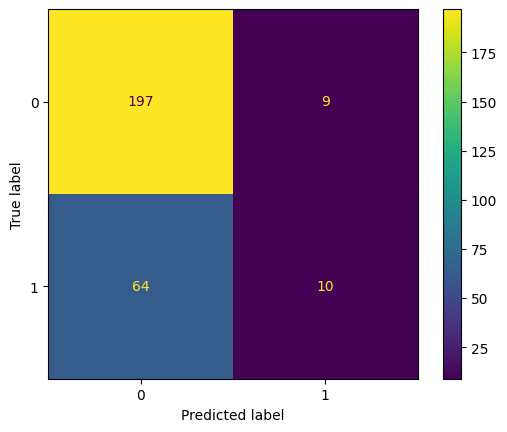

In [16]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CE_cMatrix, display_labels=CE_binary_model.classes_)
disp.plot()
plt.show()

    Method 2: Feature importance-based feature selection

In [93]:
#Feature importances for CE pair

CE_feat_importances = CE_binary_model.get_feature_importance(prettified=True)
CE_feat_importances.head(100)

,Feature Id,Importances
0,TCGAA,2.210128
1,TCTCG,1.379990
2,CTTAG,1.012284
3,AAAAC,0.990890
4,CTGGT,0.809616
...,...,...
95,AGTCA,0.226784
96,CATGA,0.224154
97,CATAT,0.221697
98,TCATC,0.218944


In [94]:
# Show only feature importances above 0.1

threshold_chosen_features = CE_feat_importances[CE_feat_importances['Importances'] >= 0.1]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importnace above 0.1 (selected features):", num_chosen_features)

    Feature Id  Importances
0        TCGAA     2.210128
1        TCTCG     1.379990
2        CTTAG     1.012284
3        AAAAC     0.990890
4        CTGGT     0.809616
..         ...          ...
317      GTAAT     0.101124
318      ATTCC     0.100776
319      TAGGA     0.100298
320      CGAGA     0.100128
321      CATCC     0.100042

[322 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 322


In [95]:
print("Sum of total feature importances: ", sum(CE_feat_importances.Importances))
print("Sum of feature importances >=0.1: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  100.00000000000009
Sum of feature importances >=0.1:  71.5077728848387


In [96]:
# Select features with importance values above 0.1

CE_selected_feat = CE_feat_importances[:num_chosen_features]['Feature Id'].tolist()

print(CE_selected_feat)

['TCGAA', 'TCTCG', 'CTTAG', 'AAAAC', 'CTGGT', 'CAAGC', 'AAAGC', 'GGGTT', 'TTTGC', 'AGAAG', 'TTCAT', 'AAGCT', 'TGGTG', 'AAGCC', 'ACAGT', 'CGCCG', 'CGCAG', 'GCGAA', 'AGCAT', 'AAGCG', 'CCTGG', 'CAGTC', 'AACCG', 'TCATG', 'TAAGA', 'AGCCA', 'GCTAC', 'CCAAG', 'GTGTT', 'AAACA', 'CTAGT', 'AGAGA', 'CTATG', 'GGTGG', 'GAAGA', 'TGAAG', 'TCAAA', 'ACATG', 'GCCAA', 'AATCG', 'AGAGT', 'GGGAT', 'CTTCG', 'GGTTG', 'GGTGA', 'TCTCA', 'AGGTG', 'CTATA', 'TGGTC', 'ATTTC', 'AAAAA', 'GAGCC', 'AGTCT', 'TGGGC', 'CTTGA', 'CATCG', 'GAATC', 'CGATC', 'CAAAC', 'AAGAG', 'TGATA', 'GGGCG', 'TCCTG', 'CTACC', 'TTGAG', 'CGAGT', 'CTCTA', 'TTGCC', 'TTACT', 'GTCTG', 'AAAGA', 'AGAGG', 'CATTT', 'GACTG', 'ACAGA', 'GTCGA', 'AGTTC', 'ACCCA', 'CTCGT', 'CAAAG', 'CCGTT', 'TGTGA', 'ATCCC', 'TGCTG', 'TACCT', 'GGTAG', 'GTACA', 'TACGG', 'TATAT', 'ACAAA', 'AGGTA', 'GGTAA', 'GACCG', 'TGACA', 'ACTAT', 'AGTCA', 'CATGA', 'CATAT', 'TCATC', 'TTTCC', 'GACTA', 'TCGTC', 'GTCTA', 'TGCAT', 'CATTC', 'GTGGA', 'GTACT', 'ACAGC', 'GGTCT', 'CTCGA', 'GGTAC', 

In [97]:
CP_ER_X_train.shape

(1120, 1024)

In [98]:
# See original training set

CP_ER_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443


In [99]:
#Create training set with selected features 

CE_X_train_selected = CP_ER_X_train[CE_selected_feat]
CE_X_train_selected.head()

,TCGAA,TCTCG,CTTAG,AAAAC,CTGGT,CAAGC,AAAGC,GGGTT,TTTGC,AGAAG,...,TATTT,AAGGC,CGTAC,ATGCT,GGGCA,GTAAT,ATTCC,TAGGA,CGAGA,CATCC
0,0.000158,0.000792,0.000475,0.000792,0.000634,0.001426,0.001742,0.000475,0.001109,0.001742,...,0.001742,0.000792,0.000158,0.000950,0.001267,0.000792,0.001109,0.001267,0.000634,0.000950
1,0.000583,0.000583,0.000000,0.000291,0.000874,0.000583,0.001457,0.000291,0.000291,0.004079,...,0.000291,0.001457,0.000000,0.001166,0.002914,0.000000,0.000583,0.000583,0.000874,0.003205
2,0.000458,0.000458,0.000917,0.001375,0.001375,0.000458,0.000917,0.000917,0.000458,0.002291,...,0.000000,0.000917,0.000458,0.000000,0.002750,0.000000,0.000458,0.000917,0.001375,0.001833
3,0.000000,0.000000,0.000990,0.000990,0.000495,0.001484,0.000000,0.000990,0.000000,0.000990,...,0.000000,0.001979,0.000000,0.000990,0.003958,0.000495,0.000000,0.000000,0.000990,0.000990
4,0.000104,0.000415,0.000933,0.002488,0.000415,0.000933,0.001244,0.001555,0.000933,0.001659,...,0.003110,0.000829,0.000104,0.001140,0.000829,0.001451,0.000933,0.000933,0.000415,0.001037


In [100]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CE_X_train_selected.columns) == CE_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [101]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CE_X_train_selected.shape)
print("Shape of y_train (number of labels):", CP_ER_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1120, 322)
Shape of y_train (number of labels): (1120,)


In [102]:
# Create pool object for selected feature data
print("Original number of features:", len(CE_feature_names), "\n Number of selected features:", len(CE_selected_feat))

CE_selected_train_pool = Pool(CE_X_train_selected, CP_ER_y_train, feature_names=CE_selected_feat)

Original number of features: 1024 
 Number of selected features: 322


In [103]:
#Create new model for data with selected features
CE_FIFS_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

# Fit new data into same model as before

CE_FIFS_model.fit(CE_selected_train_pool)

Learning rate set to 0.079585
0:	learn: 0.6791155	total: 40ms	remaining: 40s
1:	learn: 0.6684934	total: 77.2ms	remaining: 38.5s
2:	learn: 0.6541084	total: 114ms	remaining: 38s
3:	learn: 0.6432056	total: 156ms	remaining: 38.9s
4:	learn: 0.6310962	total: 195ms	remaining: 38.8s
5:	learn: 0.6207762	total: 235ms	remaining: 38.8s
6:	learn: 0.6115109	total: 273ms	remaining: 38.8s
7:	learn: 0.6039043	total: 314ms	remaining: 38.9s
8:	learn: 0.5968674	total: 353ms	remaining: 38.8s
9:	learn: 0.5877334	total: 390ms	remaining: 38.6s
10:	learn: 0.5797294	total: 426ms	remaining: 38.3s
11:	learn: 0.5727337	total: 466ms	remaining: 38.4s
12:	learn: 0.5634154	total: 504ms	remaining: 38.2s
13:	learn: 0.5582483	total: 541ms	remaining: 38.1s
14:	learn: 0.5524708	total: 579ms	remaining: 38.1s
15:	learn: 0.5451880	total: 619ms	remaining: 38.1s
16:	learn: 0.5387440	total: 657ms	remaining: 38s
17:	learn: 0.5343208	total: 693ms	remaining: 37.8s
18:	learn: 0.5272866	total: 730ms	remaining: 37.7s
19:	learn: 0.5213

In [104]:
#Check parameters used in this model fit

CE_FIFS_params = CE_FIFS_model.get_all_params()
print("Basic model parameters:", CE_FIFS_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 2.7837836742401123], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Mult

In [105]:
#Prediction using X_test only for selected features data
CE_FIFS_y_pred = CE_FIFS_model.predict(CP_ER_X_test)

#Predication probability for selected features data

CE_FIFS_y_prob = CE_FIFS_model.predict_proba(CP_ER_X_test)

In [106]:
# Calculate F1 score and get classification report

CE_FIFS_f1 = f1_score(CP_ER_y_test, CE_FIFS_y_pred, average='macro')
print(f"F1 Score: {CE_FIFS_f1}")

CE_FIFS_cr = classification_report(CP_ER_y_test, CE_FIFS_y_pred, digits=3)
print(CE_FIFS_cr)

print('Accuracy score: ', accuracy_score(CP_ER_y_test, CE_FIFS_y_pred))
# print('Roc auc score : ', roc_auc_score(CP_ER_y_test, CE_FIFS_y_prob))

F1 Score: 0.5008695652173913
              precision    recall  f1-score   support

           0      0.744     0.917     0.822       206
           1      0.346     0.122     0.180        74

    accuracy                          0.707       280
   macro avg      0.545     0.520     0.501       280
weighted avg      0.639     0.707     0.652       280

Accuracy score:  0.7071428571428572


In [107]:
# Confusion matrix for selected data

print("real values shape:", CP_ER_y_test.shape)
print("prediction shape:", CE_FIFS_y_pred.shape)

CE_FIFS_y_pred_fl = CE_FIFS_y_pred
print("flattened prediction values shape:", CE_FIFS_y_pred_fl.ravel().shape, "\n")

CE_FIFS_cMatrix = confusion_matrix(CP_ER_y_test, CE_FIFS_y_pred_fl)
print(CE_FIFS_cMatrix)

real values shape: (280,)
prediction shape: (280, 1)
flattened prediction values shape: (280,) 

[[189  17]
 [ 65   9]]


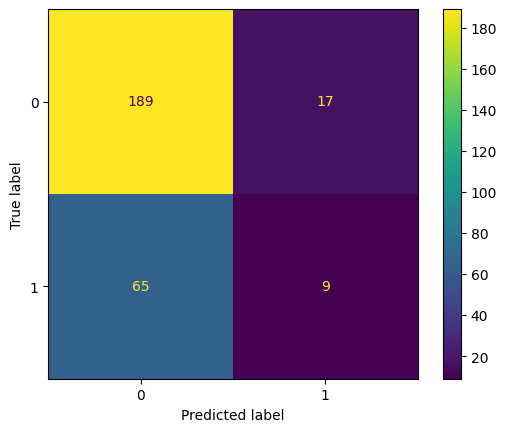

In [108]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CE_FIFS_cMatrix, display_labels=CE_FIFS_model.classes_)
disp.plot()
plt.show()

*************

    Method 7: Modelling using feature selection based on feature importance values (with get_feature_importances type = "ShapValues"), threshold > 0 with class weights accounted for

In [17]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(CE_binary_model)

In [18]:
#SHAP values for X_train
CE_shap_values = explainer.shap_values(CP_ER_X_train)

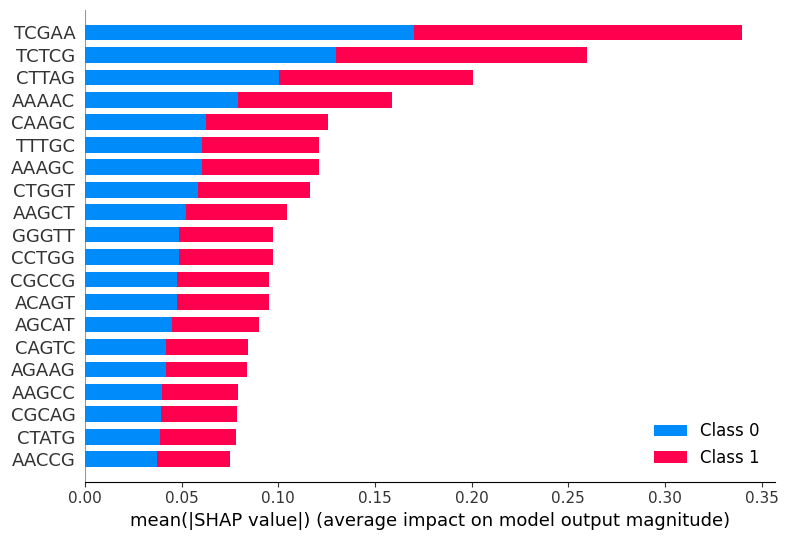

In [19]:
shap.summary_plot(CE_shap_values, CP_ER_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


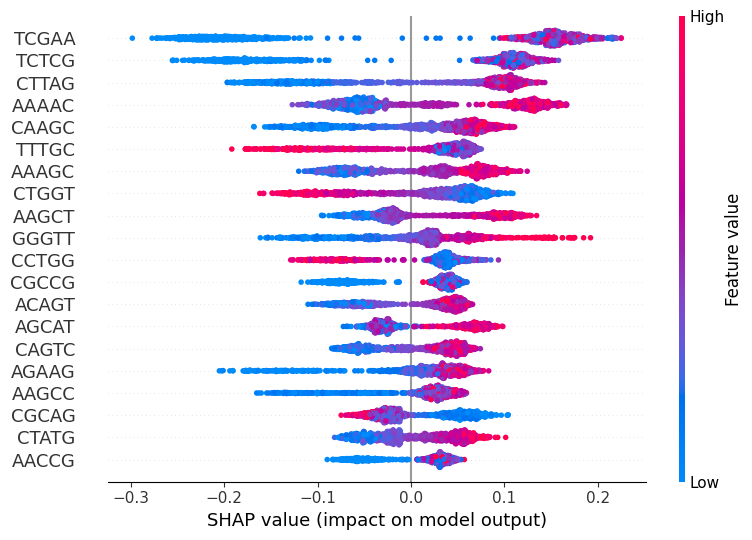

In [20]:
shap.summary_plot(CE_shap_values[0], CP_ER_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


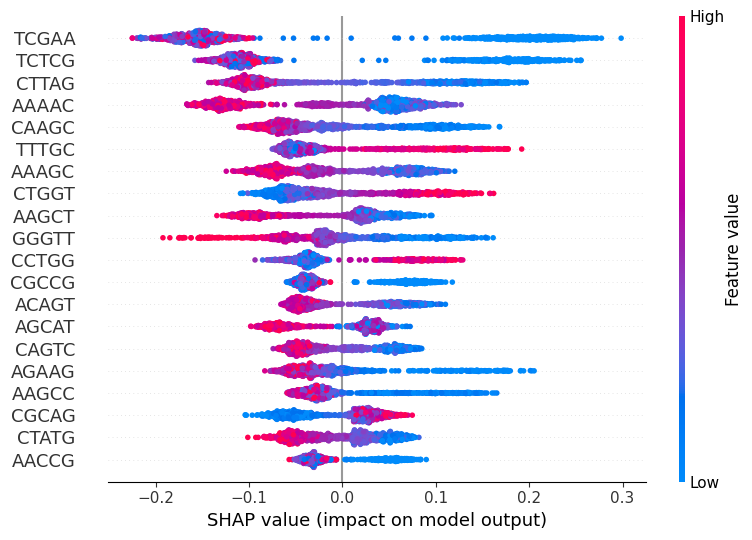

In [21]:
shap.summary_plot(CE_shap_values[1], CP_ER_X_train, plot_size=0.2)

In [22]:
shap_df = pd.DataFrame(CE_shap_values[0], columns=CP_ER_X_train.columns)


In [23]:
CE_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [24]:
# CE_shap_FI.head(50)

#### Check these feautre values with the features on shap plot for CP above #####
# Might need to use other method to get only features in with positive outcome + in red (those in red on right side):


In [25]:
# shap.summary_plot(CE_shap_values[0], CP_ER_X_train, show=False, max_display=30, plot_size=0.2)

In [26]:
# #Try####

# vals= np.abs(CE_shap_values).mean(0)

# newtry_feature_importance = pd.DataFrame(list(zip(CP_ER_X_train.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
# newtry_feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
# newtry_feature_importance

In [27]:
# newtry_feature_importance.head(10)

In [120]:
#Classifier results with CE_feature_importance

In [28]:
# Show only feature importances above 0.1

CE_SHAP_thres_chosen = CE_shap_FI[CE_shap_FI['Importances'] > 0]
CE_shap_num_chosen = len(CE_SHAP_thres_chosen)

print(CE_SHAP_thres_chosen)

print("\nAmount of features with importnace above 0.1 (selected features):", CE_shap_num_chosen)

    Feature Id  Importances
0        TCGAA     0.154469
1        TCTCG     0.109863
2        AAAAC     0.106204
3        CTTAG     0.094583
4        AAGCT     0.087003
..         ...          ...
982      TGTTA     0.000130
983      GTCAG     0.000106
984      GGGCC     0.000051
985      AGGGC     0.000042
986      TACGC     0.000037

[987 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 987


In [29]:
print("Sum of total feature importances: ", sum(CE_shap_FI.Importances))
print("Sum of feature importances >=0.1: ", sum(CE_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances >=0.1:  7.239424837203581


In [31]:
# Select features with importance values above 0.1

CE_shap_selected_feat = CE_shap_FI[:CE_shap_num_chosen]['Feature Id'].tolist()

# print(CE_shap_selected_feat)

In [32]:
CP_ER_X_train.shape

(1120, 1024)

In [33]:
# See original training set

CP_ER_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443


In [34]:
#Create training set with selected features 

CE_X_train_shap_selected = CP_ER_X_train[CE_shap_selected_feat]
CE_X_train_shap_selected.head()

,TCGAA,TCTCG,AAAAC,CTTAG,AAGCT,TCTCA,AGCAT,GAGCC,AAAGC,CGCAG,...,CGTCT,AAAAT,TTGGT,ATGGG,GCGCC,TGTTA,GTCAG,GGGCC,AGGGC,TACGC
0,0.000158,0.000792,0.000792,0.000475,0.001426,0.001267,0.001267,0.001267,0.001742,0.000475,...,0.000000,0.002218,0.001267,0.000792,0.001267,0.000792,0.000950,0.001426,0.001901,0.000158
1,0.000583,0.000583,0.000291,0.000000,0.000874,0.001166,0.000583,0.002040,0.001457,0.001748,...,0.000874,0.000291,0.001457,0.000874,0.000583,0.000583,0.002040,0.002622,0.002040,0.000291
2,0.000458,0.000458,0.001375,0.000917,0.000458,0.001833,0.000917,0.003208,0.000917,0.001833,...,0.000000,0.001375,0.000458,0.000000,0.000458,0.000458,0.000458,0.001375,0.000917,0.000000
3,0.000000,0.000000,0.000990,0.000990,0.000000,0.001979,0.001484,0.000495,0.000000,0.001484,...,0.000000,0.000000,0.000000,0.001979,0.003464,0.000495,0.001484,0.005443,0.001979,0.000000
4,0.000104,0.000415,0.002488,0.000933,0.001244,0.001244,0.000829,0.001037,0.001244,0.000518,...,0.000311,0.004354,0.001244,0.001348,0.000207,0.001140,0.000518,0.000622,0.000622,0.000415


In [35]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CE_X_train_shap_selected.columns) == CE_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [36]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CE_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", CP_ER_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1120, 987)
Shape of y_train (number of labels): (1120,)


In [37]:
# Create pool object for selected feature data
print("Original number of features:", len(CE_feature_names), "\n Number of selected features:", len(CE_shap_selected_feat))

CE_shap_selected_train_pool = Pool(CE_X_train_shap_selected, CP_ER_y_train, feature_names=CE_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 987


In [38]:
#Create new model for data with selected features
CE_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

# Fit new data into same model as before

CE_FIFS_shap_model.fit(CE_shap_selected_train_pool)

Learning rate set to 0.079585
0:	learn: 0.6817765	total: 310ms	remaining: 5m 9s
1:	learn: 0.6699772	total: 427ms	remaining: 3m 33s
2:	learn: 0.6588925	total: 568ms	remaining: 3m 8s
3:	learn: 0.6489939	total: 693ms	remaining: 2m 52s
4:	learn: 0.6361131	total: 839ms	remaining: 2m 46s
5:	learn: 0.6267610	total: 975ms	remaining: 2m 41s
6:	learn: 0.6174367	total: 1.12s	remaining: 2m 38s
7:	learn: 0.6111806	total: 1.25s	remaining: 2m 34s
8:	learn: 0.6036181	total: 1.37s	remaining: 2m 31s
9:	learn: 0.5966093	total: 1.51s	remaining: 2m 29s
10:	learn: 0.5879957	total: 1.63s	remaining: 2m 26s
11:	learn: 0.5791492	total: 1.77s	remaining: 2m 25s
12:	learn: 0.5732831	total: 1.9s	remaining: 2m 24s
13:	learn: 0.5662299	total: 2.02s	remaining: 2m 22s
14:	learn: 0.5597893	total: 2.14s	remaining: 2m 20s
15:	learn: 0.5535582	total: 2.25s	remaining: 2m 18s
16:	learn: 0.5470584	total: 2.37s	remaining: 2m 17s
17:	learn: 0.5425768	total: 2.54s	remaining: 2m 18s
18:	learn: 0.5377881	total: 2.7s	remaining: 2m 

In [40]:
#Check parameters used in this model fit

CE_FIFS_shap_params = CE_FIFS_shap_model.get_all_params()
print("Basic model parameters:", CE_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 2.7837836742401123], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Mult

In [41]:
#Prediction using X_test only for selected features data
CE_FIFS_shap_y_pred = CE_FIFS_shap_model.predict(CP_ER_X_test)

#Predication probability for selected features data

CE_FIFS_shap_y_prob = CE_FIFS_shap_model.predict_proba(CP_ER_X_test)

In [45]:
# Calculate F1 score and get classification report

print("Model 7: Feature selection (SHAP) w/ threshold > 0 \nand class imbalance accounted for - Cytoplasm & endoplasmic reticulum")

print("\nNumber of chosen features:", len(CE_shap_selected_feat), "\n")

CE_FIFS_shap_cr = classification_report(CP_ER_y_test, CE_FIFS_shap_y_pred, digits=3)
print(CE_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(CP_ER_y_test, CE_FIFS_shap_y_pred))

CE_FIFS_shap_f1 = f1_score(CP_ER_y_test, CE_FIFS_shap_y_pred, average='macro')
print(f"\nF1 Score: {CE_FIFS_shap_f1}")
# print('Roc auc score : ', roc_auc_score(CP_ER_y_test, CE_FIFS_shap_y_prob))

Model 7: Feature selection (SHAP) w/ threshold > 0 
and class imbalance accounted for - Cytoplasm & endoplasmic reticulum

Number of chosen features: 987 

              precision    recall  f1-score   support

           0      0.749     0.942     0.834       206
           1      0.429     0.122     0.189        74

    accuracy                          0.725       280
   macro avg      0.589     0.532     0.512       280
weighted avg      0.664     0.725     0.664       280

Accuracy score:  0.725

F1 Score: 0.511941143180532


In [46]:
# Confusion matrix for selected data

print("real values shape:", CP_ER_y_test.shape)
print("prediction shape:", CE_FIFS_shap_y_pred.shape)

CE_FIFS_shap_y_pred_fl = CE_FIFS_shap_y_pred
print("flattened prediction values shape:", CE_FIFS_shap_y_pred_fl.ravel().shape, "\n")

CE_FIFS_shap_cMatrix = confusion_matrix(CP_ER_y_test, CE_FIFS_shap_y_pred_fl)
print(CE_FIFS_shap_cMatrix)

real values shape: (280,)
prediction shape: (280, 1)
flattened prediction values shape: (280,) 

[[194  12]
 [ 65   9]]


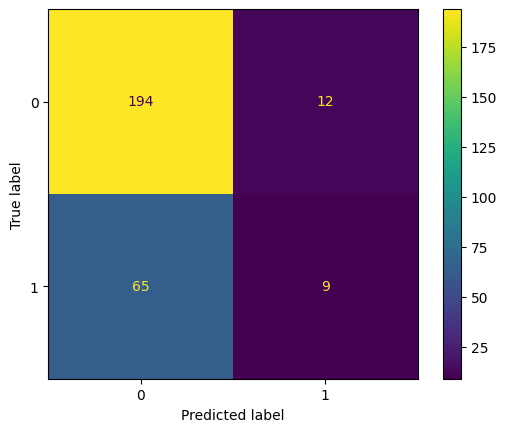

In [47]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CE_FIFS_shap_cMatrix, display_labels=CE_FIFS_shap_model.classes_)
disp.plot()
plt.show()

In [136]:
#Classifier results with newtry_feature_importance

In [137]:
newtry_feature_importance.head(66)

,col_name,feature_importance_vals
864,TCGAA,190.295301
886,TCTCG,145.336767
498,CTTAG,112.421686
1,AAAAC,88.779323
265,CAAGC,70.281483
...,...,...
800,TAGAA,17.643577
1006,TTGTG,17.600895
467,CTCAT,17.489685
592,GCCAA,17.480704


In [138]:
# Show only feature importances above 0.1

CE_newSHAP_thres_chosen = newtry_feature_importance[newtry_feature_importance["feature_importance_vals"] >= 13.4]
CE_newshap_num_chosen = len(CE_newSHAP_thres_chosen)

print(CE_newSHAP_thres_chosen)

print("\nAmount of features with importnace above 0.1 (selected features):", CE_newshap_num_chosen)

     col_name  feature_importance_vals
864     TCGAA               190.295301
886     TCTCG               145.336767
498     CTTAG               112.421686
1       AAAAC                88.779323
265     CAAGC                70.281483
...       ...                      ...
823     TATCT                13.817389
636     GCTTA                13.746805
1001    TTGGC                13.616189
842     TCAGG                13.542109
122     ACTGG                13.400597

[141 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 141


In [139]:
print("Sum of total feature importances: ", sum(newtry_feature_importance.feature_importance_vals))
print("Sum of feature importances >=0.1: ", sum(CE_newSHAP_thres_chosen.feature_importance_vals))

Sum of total feature importances:  7901.666612062278
Sum of feature importances >=0.1:  4058.3953847348002


In [140]:
# Select features with importance values above 0.1

CE_newshap_selected_feat = newtry_feature_importance[:CE_newshap_num_chosen]['col_name'].tolist()

print(CE_newshap_selected_feat)

['TCGAA', 'TCTCG', 'CTTAG', 'AAAAC', 'CAAGC', 'TTTGC', 'AAAGC', 'CTGGT', 'AAGCT', 'GGGTT', 'CCTGG', 'CGCCG', 'ACAGT', 'AGCAT', 'CAGTC', 'AGAAG', 'AAGCC', 'CGCAG', 'CTATG', 'AACCG', 'AAGCG', 'ACATG', 'TTCAT', 'GAGCC', 'TGGTG', 'CCAAG', 'TAAGA', 'CTTCG', 'ATTTC', 'GCTAC', 'TCATG', 'GAAGA', 'TGAAG', 'TGGTC', 'GCGAA', 'AATCG', 'CATCG', 'TCTCA', 'TCAAA', 'CGATC', 'AAACA', 'GGGAT', 'AGCCA', 'AAAAA', 'AGTTC', 'GCGGT', 'GGTGA', 'AGGTG', 'AGAGT', 'AGAGG', 'AGAGA', 'CAATA', 'TGCAT', 'GTACC', 'CTCTA', 'GGTGG', 'GTACA', 'TGACA', 'ACAGA', 'TGCTG', 'CTATA', 'ATCCC', 'AGTCT', 'TTACT', 'TCCTG', 'AGCAC', 'CATAT', 'TACGG', 'CTTGA', 'CTAGT', 'TTGAG', 'GGTAA', 'CTCGT', 'GGTTG', 'GACTG', 'GAATC', 'CAAAC', 'ACCGT', 'CCACC', 'AACAC', 'GTCGA', 'ACAAA', 'CTACC', 'AAAGA', 'GGGCG', 'AAGAG', 'TGTGA', 'TACCT', 'CTCGA', 'CGAGT', 'CGAGG', 'GTACT', 'CAAAG', 'AGTAC', 'GTGTT', 'AAGCA', 'TTTCT', 'TCCAG', 'CAGAA', 'TAGAA', 'TTGTG', 'CTCAT', 'GCCAA', 'TTGCA', 'TATAT', 'GGAAA', 'GTCTA', 'CGGAT', 'TCATC', 'AGGGT', 'AAGAT', 

In [141]:
CP_ER_X_train.shape

(1120, 1024)

In [142]:
# See original training set

CP_ER_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443


In [143]:
#Create training set with selected features 

CE_X_train_newshap_selected = CP_ER_X_train[CE_newshap_selected_feat]
CE_X_train_newshap_selected.head()

,TCGAA,TCTCG,CTTAG,AAAAC,CAAGC,TTTGC,AAAGC,CTGGT,AAGCT,GGGTT,...,ACCGG,GGAAT,AGACT,ACCCA,GCCGC,TATCT,GCTTA,TTGGC,TCAGG,ACTGG
0,0.000158,0.000792,0.000475,0.000792,0.001426,0.001109,0.001742,0.000634,0.001426,0.000475,...,0.000317,0.001267,0.001267,0.001109,0.000950,0.000475,0.000000,0.000317,0.000634,0.001584
1,0.000583,0.000583,0.000000,0.000291,0.000583,0.000291,0.001457,0.000874,0.000874,0.000291,...,0.001166,0.000874,0.000291,0.002040,0.002622,0.000291,0.000583,0.000874,0.000874,0.000291
2,0.000458,0.000458,0.000917,0.001375,0.000458,0.000458,0.000917,0.001375,0.000458,0.000917,...,0.000000,0.000000,0.000458,0.001375,0.000917,0.000000,0.000458,0.000458,0.000458,0.000917
3,0.000000,0.000000,0.000990,0.000990,0.001484,0.000000,0.000000,0.000495,0.000000,0.000990,...,0.000495,0.000990,0.000990,0.000000,0.002474,0.001484,0.000495,0.000495,0.000495,0.000990
4,0.000104,0.000415,0.000933,0.002488,0.000933,0.000933,0.001244,0.000415,0.001244,0.001555,...,0.000207,0.000726,0.000726,0.001037,0.000415,0.001244,0.001140,0.000829,0.001244,0.000829


In [144]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CE_X_train_newshap_selected.columns) == CE_newshap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [145]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CE_X_train_newshap_selected.shape)
print("Shape of y_train (number of labels):", CP_ER_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1120, 141)
Shape of y_train (number of labels): (1120,)


In [146]:
# Create pool object for selected feature data
print("Original number of features:", len(CE_feature_names), "\n Number of selected features:", len(CE_newshap_selected_feat))

CE_newshap_selected_train_pool = Pool(CE_X_train_newshap_selected, CP_ER_y_train, feature_names=CE_newshap_selected_feat)

Original number of features: 1024 
 Number of selected features: 141


In [147]:
#Create new model for data with selected features
CE_FIFS_newshap_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

# Fit new data into same model as before

CE_FIFS_newshap_model.fit(CE_newshap_selected_train_pool)

Learning rate set to 0.079585
0:	learn: 0.6817247	total: 24.3ms	remaining: 24.2s
1:	learn: 0.6658120	total: 41ms	remaining: 20.4s
2:	learn: 0.6542171	total: 57ms	remaining: 19s
3:	learn: 0.6427553	total: 73.9ms	remaining: 18.4s
4:	learn: 0.6328966	total: 91.8ms	remaining: 18.3s
5:	learn: 0.6229527	total: 109ms	remaining: 18.1s
6:	learn: 0.6127699	total: 129ms	remaining: 18.2s
7:	learn: 0.6031994	total: 147ms	remaining: 18.2s
8:	learn: 0.5936912	total: 165ms	remaining: 18.1s
9:	learn: 0.5871446	total: 182ms	remaining: 18s
10:	learn: 0.5786755	total: 200ms	remaining: 18s
11:	learn: 0.5703478	total: 217ms	remaining: 17.8s
12:	learn: 0.5615342	total: 235ms	remaining: 17.9s
13:	learn: 0.5531887	total: 253ms	remaining: 17.8s
14:	learn: 0.5455195	total: 270ms	remaining: 17.7s
15:	learn: 0.5397148	total: 286ms	remaining: 17.6s
16:	learn: 0.5342506	total: 306ms	remaining: 17.7s
17:	learn: 0.5272113	total: 324ms	remaining: 17.7s
18:	learn: 0.5226696	total: 344ms	remaining: 17.7s
19:	learn: 0.517

In [148]:
#Check parameters used in this model fit

CE_FIFS_newshap_params = CE_FIFS_newshap_model.get_all_params()
print("Basic model parameters:", CE_FIFS_newshap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 2.7837836742401123], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Mult

In [149]:
#Prediction using X_test only for selected features data
CE_FIFS_newshap_y_pred = CE_FIFS_newshap_model.predict(CP_ER_X_test)

#Predication probability for selected features data

CE_FIFS_newshap_y_prob = CE_FIFS_newshap_model.predict_proba(CP_ER_X_test)

In [150]:
# Calculate F1 score and get classification report

CE_FIFS_newshap_f1 = f1_score(CP_ER_y_test, CE_FIFS_newshap_y_pred, average='macro')
print(f"F1 Score: {CE_FIFS_newshap_f1}")

CE_FIFS_newshap_cr = classification_report(CP_ER_y_test, CE_FIFS_newshap_y_pred, digits=3)
print(CE_FIFS_newshap_cr)

print('Accuracy score: ', accuracy_score(CP_ER_y_test, CE_FIFS_newshap_y_pred))
# print('Roc auc score : ', roc_auc_score(CP_ER_y_test, CE_FIFS_newshap_y_prob))

F1 Score: 0.5495652173913044
              precision    recall  f1-score   support

           0      0.760     0.937     0.839       206
           1      0.500     0.176     0.260        74

    accuracy                          0.736       280
   macro avg      0.630     0.556     0.550       280
weighted avg      0.691     0.736     0.686       280

Accuracy score:  0.7357142857142858


In [151]:
# Confusion matrix for selected data

print("real values shape:", CP_ER_y_test.shape)
print("prediction shape:", CE_FIFS_newshap_y_pred.shape)

CE_FIFS_newshap_y_pred_fl = CE_FIFS_newshap_y_pred
print("flattened prediction values shape:", CE_FIFS_newshap_y_pred_fl.ravel().shape, "\n")

CE_FIFS_newshap_cMatrix = confusion_matrix(CP_ER_y_test, CE_FIFS_newshap_y_pred_fl)
print(CE_FIFS_newshap_cMatrix)

real values shape: (280,)
prediction shape: (280, 1)
flattened prediction values shape: (280,) 

[[193  13]
 [ 61  13]]


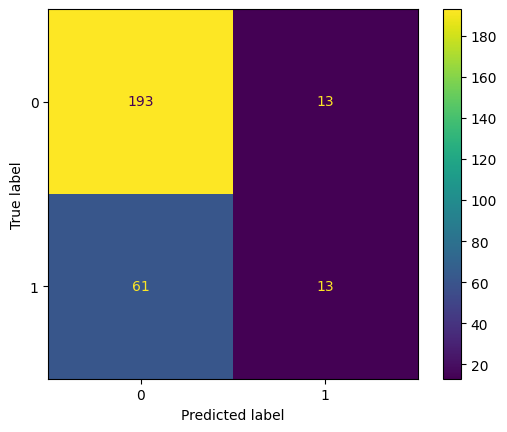

In [152]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CE_FIFS_newshap_cMatrix, display_labels=CE_FIFS_newshap_model.classes_)
disp.plot()
plt.show()

*************
BELOW (POSSIBLY) NOT NECESSARY WHEN ABOVE IS USED
************